# Set Environment
Import the libaries need to handle html formats and data tables

In [1]:
import pandas as pd # used to handle dataframes/tables
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# categorical ordered type
from pandas.api.types import CategoricalDtype

# stats libary
from scipy import stats
from scipy.stats import mannwhitneyu

# 20 random inputs

The blacklist (bl) and greenscreen (gs) were both made using 20 random inputs. 

Note that the blacklist tool is hard-coded to find blacklist regions in the human genome. Therefore, to account for Arabidopsis having a smaller genome, the line of code that merges significant regions together had to be manually modified to merge regions within 5kb rather than 20kb. 

Greenscreen regions were generated by first running each input sample through MACS2 v2.2.7.1 (—keepdup “auto” —no model –extsize [read length] —broad --nolambda  -g 101274395). Peaks with average q-values (column 9 in the broadPeak output file) above 10-10 were filtered out. Peaks called from the individual inputs were concatenated, and all peaks within a 5kb distance were merged.

In [2]:
#hard code to file paths
gs_file="../data/arabidopsis_greenscreen_20inputs.bed"
bl_file="../data/arabidopsis_blacklist_20inputs.bed"

## Length of masked regions
In the code below we want to make a boxplot to compare the length of regions found by the blacklist and greenscreen methods.

bed and narrowPeak files both contain genome location information. The first 3 columns are mandatory, but the first 6 columns in both file times share the same information.

In [3]:
bed_cols=["chr","start","stop","name","score","strand"]
np_cols=bed_cols+["fc","pval","qval","summit"]

import the greenscreen and blacklist regions into python

In [4]:
gs_df = pd.read_csv(gs_file, header=None, sep="\t")
bl_df = pd.read_csv(bl_file, header=None, sep="\t")

In [5]:
gs_df.columns = np_cols[0:gs_df.shape[1]]
bl_df.columns = np_cols[0:bl_df.shape[1]]
gs_df["mask"]="GS"
bl_df["mask"]="BL"

concatonate the two tables and get the length of each region

In [6]:
as_df = gs_df.append(bl_df)
as_df["len"]=as_df["stop"]-as_df["start"]

change the values of the mask labels

In [7]:
# change mask labels
as_df["mask"] = (
    as_df["mask"].replace(
    ["GS","noMask","BL"],["Green screen","no Mask","Blacklist"]))

mask_cat_type = CategoricalDtype(categories=["no Mask", "Green screen","Blacklist"], ordered=True)
as_df["mask"] = as_df["mask"].astype(mask_cat_type)
as_df["mask"].cat.remove_unused_categories(inplace=True)

/home/sklasfeld/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


create a log10 boxplot comparing the GS and BL regions

In [9]:
as_df["log10len"] = np.log10(as_df["len"])

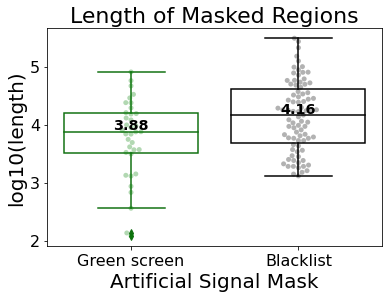

In [10]:
fig,(ax1) = plt.subplots(1)

# generate boxplot
box_plot = sns.boxplot(x="mask", y="log10len", ax=ax1, 
                 palette=sns.color_palette(["green","black"]),
                 data=as_df)
# use swarmplot() to show the data points on top of the box plots
sns.swarmplot(x="mask", y="log10len", ax=ax1, 
                 palette=sns.color_palette(["green","black"]),
                 data=as_df, alpha=0.3)
# reformat y-ticks
#ticks_loc = ax1.get_yticks().tolist()
#ax1.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
#ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax1.get_yticks()/1000]
#ax1.set_yticklabels(ylabels)
# set title and x label
ax1.set_title('Length of Masked Regions',fontsize=22)
ax1.set_xlabel('Artificial Signal Mask',fontsize=20)
ax1.set_ylabel('log10(length)',fontsize=20)
ax1.tick_params(labelsize=16)

for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

        
medians = as_df.groupby(['mask'])['log10len'].median()
vertical_offset = as_df['log10len'].median() * 0.01 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
plt.show()

# Statistical Testing
We are interested in comparing whether the average regions lengths in greenscreen and blacklist are statisically similar. First let us plot the distributions of the two groups.

/home/sklasfeld/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


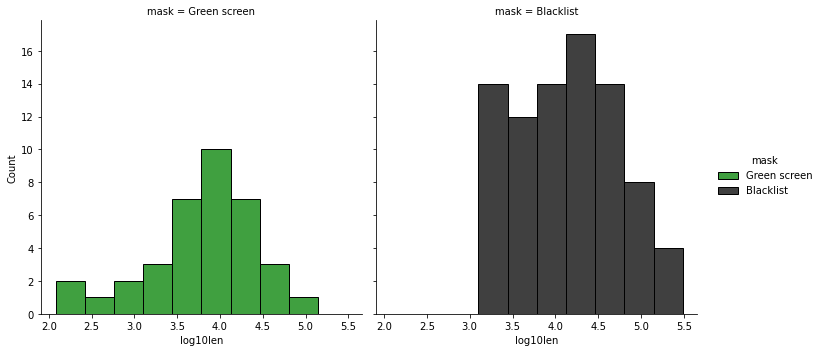

In [11]:
sns.displot(col="mask", x="log10len", hue="mask", ax=ax1, 
                 palette=sns.color_palette(["green","black"]),
                 data=as_df, bins=10)
plt.show()

It is hard to tell whether they both have normal distributions so let us get more information about the mean and standard deviation.

In [12]:
gs_len_series = as_df.loc[as_df["mask"]=="Green screen","log10len"]
gs_len_series.describe()

count    36.000000
mean      3.763416
std       0.678851
min       2.079181
25%       3.513137
50%       3.875320
75%       4.193291
max       4.907632
Name: log10len, dtype: float64

In [13]:
bl_len_series = as_df.loc[as_df["mask"]=="Blacklist","log10len"]
bl_len_series.describe()

count    83.000000
mean      4.141444
std       0.606090
min       3.113943
25%       3.688744
50%       4.164353
75%       4.605827
max       5.488974
Name: log10len, dtype: float64

Observations
* The variance in both groups are very similar.
* The medians and the means are relatively similar so we can make a normal distribution assumption

In [14]:
stats.ttest_ind(gs_len_series, bl_len_series, equal_var=True, alternative='less')

Ttest_indResult(statistic=-3.0127961181720293, pvalue=0.0015866840837129531)